## Imports

In [1]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

from fastprogress.fastprogress import master_bar, progress_bar

from jupyterthemes import jtplot

from torch.utils.data import DataLoader, Subset, Dataset
from torchsummary import summary
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, Normalize, ToTensor
from torchvision.utils import make_grid
from torchvision import transforms

from PIL import Image

from pathlib import Path
from tqdm import tqdm

import os

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

jtplot.style(context="talk")

In [2]:
#makes github ignore all the data

with open(".gitignore", "w") as f:
    f.write("""
# Ignore image data folders
tiny-imagenet-200/
tiny-imagenet-200-grayscale/

# Ignore any .DS_Store or similar files
.DS_Store

# Ignore Python cache files
__pycache__/
*.pyc
""")


## Dataset Download

In [3]:
# Download download Tiny ImageNet directly into your Jupyter Notebook if it doesn't already exist

import os
import requests
import zipfile

# set directory and download URL
url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
output_dir = "tiny-imagenet-200"
zip_filename = "tiny-imagenet-200.zip"

# download zip file if it doesn't exist
if not os.path.exists(zip_filename):
    print("Downloading Tiny ImageNet...")
    r = requests.get(url, stream=True)
    with open(zip_filename, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
    print("Download complete.")

# unzip if not already extracted
if not os.path.exists(output_dir):
    print("Extracting zip file...")
    with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
        zip_ref.extractall()
    print("Extraction complete.")
else:
    print("Already extracted.")



Extracting zip file...
Extraction complete.


In [4]:
# Convert RGB to grayscale images
def convert_jpegs_to_bw(source_root, dest_root):
    source_root = Path(source_root)
    dest_root = Path(dest_root)

    dest_root.mkdir(parents=True, exist_ok=True)

    # Collect all image paths
    all_files = []
    for root, dirs, files in os.walk(source_root):
        for file in files:
            if file.lower().endswith((".jpg", ".jpeg", ".png", ".jpeg".upper(), ".jpg".upper())):
                all_files.append((root, file))

    # Convert images if they aren't already converted
    for root, file in tqdm(all_files, desc="Converting images"):
        source_path = Path(root) / file
        relative_path = source_path.relative_to(source_root)
        dest_path = dest_root / relative_path

        dest_path.parent.mkdir(parents=True, exist_ok=True)

        # Skip if already converted
        if dest_path.exists():
            continue

        try:
            img = Image.open(source_path).convert("L")
            img.save(dest_path)
        except Exception as e:
            print(f"Failed to process {source_path}: {e}")

# Loop through each split and only convert if needed
splits = ["train", "val", "test"]
for split in splits:
    source = f"tiny-imagenet-200/{split}"
    dest = f"tiny-imagenet-200-grayscale/{split}"

    # Only run if destination is missing or empty
    if not os.path.exists(dest) or not any(Path(dest).rglob("*.[jp][pn]g")):
        print(f"\n📂 Converting: {split}")
        convert_jpegs_to_bw(source, dest)
    else:
        print(f"✅ Skipped: {split} already exists and contains images.")


📂 Converting: train


Converting images: 100%|██████████| 100000/100000 [00:47<00:00, 2103.00it/s]



📂 Converting: val


Converting images: 100%|██████████| 10000/10000 [00:04<00:00, 2101.83it/s]



📂 Converting: test


Converting images: 100%|██████████| 10000/10000 [00:04<00:00, 2119.99it/s]


In [5]:
print(os.getcwd())

/home/jmpb2020/Tintelligence/notebooks


## Dataset Utility

In [12]:
class ColorizationDataset(Dataset):
    def __init__(self, grayscale_dir, color_dir, transform_input=None, transform_target=None, use_annotations=False):
        self.grayscale_dir = grayscale_dir
        self.color_dir = color_dir
        self.transform_input = transform_input
        self.transform_target = transform_target
        self.samples = []

        if use_annotations:
            # Handle val/ layout using val_annotations.txt
            annotation_path = os.path.join(color_dir, "val_annotations.txt")
            with open(annotation_path, "r") as f:
                for line in f:
                    parts = line.strip().split("\t")
                    filename = parts[0]
                    class_name = parts[1]
                    color_img_path = os.path.join(color_dir, "images", filename)
                    gray_img_path = os.path.join(grayscale_dir, "images", filename)

                    if os.path.exists(color_img_path) and os.path.exists(gray_img_path):
                        self.samples.append((gray_img_path, color_img_path))
        else:
            # Regular nested folder structure
            for class_name in os.listdir(grayscale_dir):
                gray_class_path = os.path.join(grayscale_dir, class_name, "images")
                color_class_path = os.path.join(color_dir, class_name, "images")
                if not os.path.isdir(gray_class_path):
                    continue

                for img_name in os.listdir(gray_class_path):
                    gray_img_path = os.path.join(gray_class_path, img_name)
                    color_img_path = os.path.join(color_class_path, img_name)
                    if os.path.exists(color_img_path):
                        self.samples.append((gray_img_path, color_img_path))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        gray_path, color_path = self.samples[idx]
        gray = Image.open(gray_path).convert("L")
        color = Image.open(color_path).convert("RGB")

        if self.transform_input:
            gray = self.transform_input(gray)
        if self.transform_target:
            color = self.transform_target(color)

        return gray, color


In [13]:
def get_colorization_loader(grayscale_path, color_path, batch_size=32, use_annotations=False):
    transform_input = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
    ])

    transform_target = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
    ])

    dataset = ColorizationDataset(grayscale_path, color_path, transform_input, transform_target, use_annotations)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return loader



In [14]:
import os

print("Grayscale root exists:", os.path.exists("tiny-imagenet-200-grayscale"))
print("Grayscale train exists:", os.path.exists("tiny-imagenet-200-grayscale/train"))
print("Sample class folders:", os.listdir("../tiny-imagenet-200-grayscale/train")[:5] if os.path.exists("../tiny-imagenet-200-grayscale/train") else "❌ No /train folder")


Grayscale root exists: True
Grayscale train exists: True
Sample class folders: ❌ No /train folder


In [15]:
import os

print("Grayscale images in val:", len(os.listdir("tiny-imagenet-200-grayscale/val")))
print("Color images in val:", len(os.listdir("tiny-imagenet-200/val")))


Grayscale images in val: 1
Color images in val: 2


In [59]:
grayscale_path = "./tiny-imagenet-200-grayscale/train"
color_path = "./tiny-imagenet-200/train"

train_loader = get_colorization_loader(
    "tiny-imagenet-200-grayscale/train", 
    "tiny-imagenet-200/train", 
    batch_size=64,
    use_annotations=False
)

valid_loader = get_colorization_loader(
    "tiny-imagenet-200-grayscale/val", 
    "tiny-imagenet-200/val", 
    batch_size=64,
    use_annotations=True
)


# test_loader = get_colorization_loader(
#     "tiny-imagenet-200-grayscale/test", 
#     "tiny-imagenet-200/test", 
#     batch_size=32,
# )

## Training Utility

In [21]:
def train_one_epoch(mb, loader, device, model, criterion, optimizer):

    model.train()

    losses = []

    num_batches = len(loader)
    dataiterator = iter(loader)

    for batch in progress_bar(range(num_batches), parent=mb):

        mb.child.comment = "Training"

        # Grab the batch of data and send it to the correct device
        X, Y = next(dataiterator)
        X, Y = X.to(device), Y.to(device)

        # Compute the output
        output = model(X)

        # Compute loss
        loss = criterion(output, Y)
        losses.append(loss.item())

        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return losses

## Validation Utility

In [43]:
def validate(mb, loader, device, model, criterion):
    model.eval()
    losses = []
    with torch.no_grad():
        for gray, color in loader:
            gray, color = gray.to(device), color.to(device)
            output = model(gray)
            loss = criterion(output, color)
            losses.append(loss.item())

    avg_loss = sum(losses) / len(losses)
    return losses, None, None


## Loss Plotting Utility

In [44]:
def update_plots(mb, train_losses, valid_losses, epoch, num_epochs):

    # Update plot data
    max_loss = max(max(train_losses), max(valid_losses))
    min_loss = min(min(train_losses), min(valid_losses))

    x_margin = 0.2
    x_bounds = [0 - x_margin, num_epochs + x_margin]

    y_margin = 0.1
    y_bounds = [min_loss - y_margin, max_loss + y_margin]

    train_xaxis = torch.linspace(0, epoch + 1, len(train_losses))
    valid_xaxis = torch.linspace(0, epoch + 1, len(valid_losses))
    graph_data = [[train_xaxis, train_losses], [valid_xaxis, valid_losses]]

    mb.update_graph(graph_data, x_bounds, y_bounds)

## Data Loading

In [45]:
# TODO: tune the training batch size
train_batch_size = 128

# Let's use some shared space for the data (so that we don't have copies
# sitting around everywhere)
data_path = "~/data"

# Use the GPUs if they are available
# TODO: if you run into GPU memory errors you should set device to "cpu" and restart the notebook
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using '{device}' device.")

valid_batch_size = 5000
grayscale_path = "./tiny-imagenet-200-grayscale/train"
color_path = "./tiny-imagenet-200/train"
train_loader = get_colorization_loader(grayscale_path, color_path, batch_size=8)

# Input and output sizes depend on data
class_names = sorted(os.listdir(grayscale_path))
num_classes = 3

# print(class_names)

Using 'cuda' device.


## Model Creation

In [46]:
class NeuralNetwork(nn.Module):
    def __init__(self, layer_sizes):
        super().__init__()

        # The first "layer" just rearranges an image into a column vector
        first_layer = nn.Flatten()

        # The hidden layers include:
        # 1. a linear component (computing Z) and
        # 2. a non-linear comonent (computing A)
        # TODO: add dropout and/or batch normalization
        hidden_layers = [
            nn.Sequential(nn.Linear(nlminus1, nl), nn.ReLU())
            for nl, nlminus1 in zip(layer_sizes[1:-1], layer_sizes)
        ]

        # The output layer must be Linear without an activation. See:
        #   https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
        output_layer = nn.Linear(layer_sizes[-2], layer_sizes[-1])

        # Group all layers into the sequential container
        all_layers = [first_layer, *hidden_layers, output_layer]
        self.layers = nn.Sequential(*all_layers)

    def forward(self, X):
        return self.layers(X)

In [47]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # TODO: create layers here

        # Early CNNs had the following structure:
        #    X -> [[Conv2d -> ReLU] x N -> MaxPool2d] x M
        #      -> [Linear -> ReLU] x K -> Linear
        #   Where
        #     0 ≤ N ≤ 3
        #     0 ≤ M ≤ 3
        #     0 ≤ K < 3
        #
        # The "[[Conv2d -> ReLU] x N -> MaxPool2d] x M" part extracts
        # useful features, and the "[Linear -> ReLU] x K -> Linear" part
        # performs the classification.
        self.conv_layers = nn.Sequential(
            # Conv layer 1: (3 input channels, 32 output channels)
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # downsample by 2

            # Conv layer 2: (32 input channels, 64 output channels)
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # downsample again
        )

        # After two max-pool layers on 32x32 input → 8x8 feature maps
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  # flatten the output from conv layers
            nn.Linear(64 * 8 * 8, 128),  # fully connected layer
            nn.ReLU(),
            nn.Linear(128, 10)  # 10 output classes for CIFAR-10
        )

    def forward(self, X):

        # TODO: implement forward pass here
        X = self.conv_layers(X)
        X = self.fc_layers(X)
        return X

In [60]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Simple CNN
class ColorizationCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),  # grayscale input
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.MaxPool2d(2, 2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 2, stride=2),  # 3-channel output
            nn.Sigmoid()  # values in [0, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [61]:
# TODO: try out different network widths and depths
# neurons_per_hidden_layer = [1024, 512, 256]
# layer_sizes = [num_features, *neurons_per_hidden_layer, num_classes]
# model = NeuralNetwork(layer_sizes).to(device)

# TODO: complete the CNN class in the cell above this one and then uncomment this line
# model = CNN().to(device)

# TODO: use an off-the-shell model from PyTorch
# from torchvision.models import ...
# model = ...

# TINT TODO: make the output have 3 nodes.
# from torchvision.models import resnet18
# model = resnet18(num_classes=num_classes).to(device)

# summary(model)

#TINT
# Instantiate the model
model = ColorizationCNN().to(device)
summary(model)
# pixel-wise loss
criterion = nn.MSELoss()

# TODO: try out different Adam hyperparameters
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # or 5e-5
criterion = nn.MSELoss()

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       640
|    └─ReLU: 2-2                         --
|    └─Dropout: 2-3                      --
|    └─MaxPool2d: 2-4                    --
|    └─Conv2d: 2-5                       73,856
|    └─ReLU: 2-6                         --
|    └─Dropout: 2-7                      --
|    └─MaxPool2d: 2-8                    --
├─Sequential: 1-2                        --
|    └─ConvTranspose2d: 2-9              32,832
|    └─ReLU: 2-10                        --
|    └─ConvTranspose2d: 2-11             771
|    └─Sigmoid: 2-12                     --
Total params: 108,099
Trainable params: 108,099
Non-trainable params: 0


In [62]:
# Test single batch

gray_batch, color_batch = next(iter(train_loader))
gray_batch, color_batch = gray_batch.to(device), color_batch.to(device)
output = model(gray_batch)
print("Output shape:", output.shape)  # Should be [batch_size, 3, 64, 64]


Output shape: torch.Size([64, 3, 64, 64])


## Training and Analysis

In [63]:
# Validate paths:
print("Train size:", len(train_loader.dataset))
print("Valid size:", len(valid_loader.dataset))


Train size: 100000
Valid size: 10000


In [64]:
train_samples = set([p[0] for p in train_loader.dataset.samples])
valid_samples = set([p[0] for p in valid_loader.dataset.samples])
print("Overlap:", len(train_samples.intersection(valid_samples)))


Overlap: 0


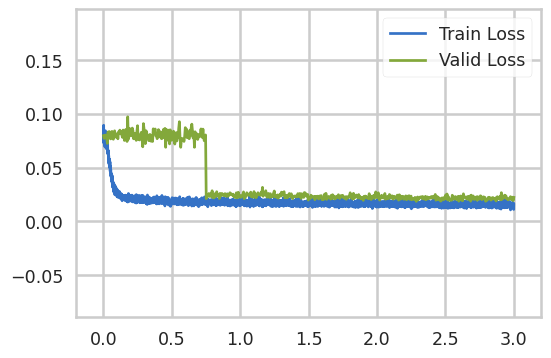

In [65]:
# TODO: tune the number of epochs
num_epochs = 3

train_losses = []
valid_losses = []
accuracies = []

# A master bar for fancy output progress
mb = master_bar(range(num_epochs))
mb.names = ["Train Loss", "Valid Loss"]
mb.main_bar.comment = f"Epochs"

# Loss and accuracy prior to training
vl, accuracy, _ = validate(None, valid_loader, device, model, criterion)
valid_losses.extend(vl)
accuracies.append(accuracy)

for epoch in mb:

    tl = train_one_epoch(mb, train_loader, device, model, criterion, optimizer)
    train_losses.extend(tl)

    vl, accuracy, acc_by_class = validate(mb, valid_loader, device, model, criterion)
    valid_losses.extend(vl)
    accuracies.append(accuracy)

    update_plots(mb, train_losses, valid_losses, epoch, num_epochs)

In [69]:
import matplotlib.pyplot as plt
import numpy as np

def show_colorization_examples(model, loader, device, num_examples=5):
    model.eval()
    gray_batch, color_batch = next(iter(loader))
    gray_batch = gray_batch[:num_examples].to(device)
    color_batch = color_batch[:num_examples].to(device)

    with torch.no_grad():
        outputs = model(gray_batch)

    gray_batch = gray_batch.cpu().numpy()
    color_batch = color_batch.cpu().numpy()
    outputs = outputs.cpu().numpy()

    fig, axs = plt.subplots(num_examples, 3, figsize=(10, 4 * num_examples))

    for i in range(num_examples):
        axs[i, 0].imshow(gray_batch[i][0], cmap='gray')
        axs[i, 0].set_title("Input (Grayscale)")
        axs[i, 1].imshow(np.transpose(outputs[i], (1, 2, 0)))
        axs[i, 1].set_title("Predicted Color")
        axs[i, 2].imshow(np.transpose(color_batch[i], (1, 2, 0)))
        axs[i, 2].set_title("Ground Truth Color")

        for ax in axs[i]:
            ax.axis("off")

    plt.tight_layout()
    plt.show()


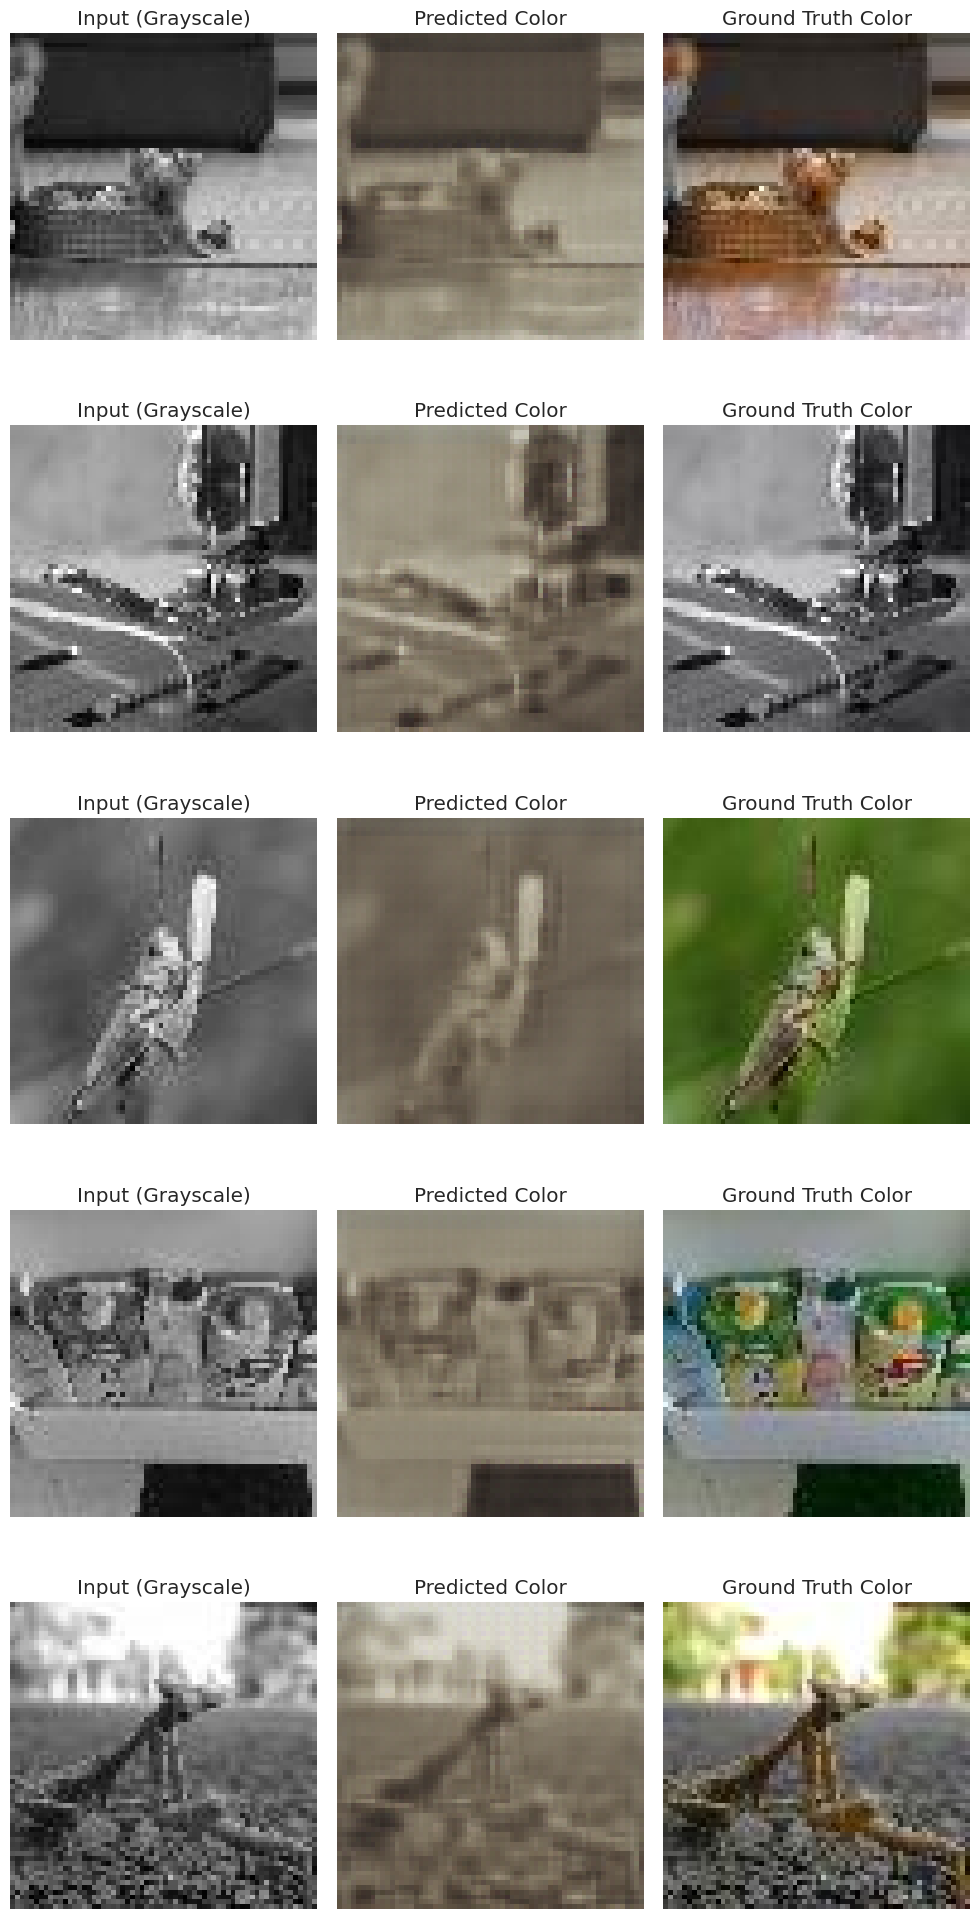

In [70]:
show_colorization_examples(model, valid_loader, device)

In [68]:
y_trues = []
y_preds = []
model.to(device)
for x, y in valid_loader:
    y_trues.append(y.cpu())
    y_preds.append(model(x.to(device)).argmax(dim=1).cpu())

y_true = torch.hstack(y_trues)
y_pred = torch.hstack(y_preds)

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 64 but got size 16 for tensor number 156 in the list.

In [ ]:
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names).plot();
plt.grid(False)

In [ ]:
# TODO: Take the three outputs and reconstruct an image